<h1 align="center">Volume 3: Data Augmentation.</h1>

    Rachel Bennett
    Math 403
    Oct 19,2021

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn import datasets
from imageio import imread
import numpy as np
from sklearn.metrics import classification_report
#from google.colab import drive
#drive.mount('/content/gdrive')
import librosa
import random

<h2 align="center">Image Augmentation</h2>

<h3 align="center">Problem 1</h3>

In [35]:
def translate(images, A, B): 
    """Returns each image translated by a random amount (a,b), where
    a~Uniform(-A,A) and b~Uniform(-B,B). The resulting image should be cropped
    to be of size (d1,d2). Note that this translation will leave a border on
    two sides of the image. Fill the empty border with the parts that were cropped
    off the opposite sides.
        Parameters:
            images (d1,d2): d1 x d2 array 
            A (float): horizontal translation parameter
            B (float): vertical translation parameter
        Returns:
            translated_image (d1,d2): array of translated images
    """
    d1, d2 = images.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2)) #Need to reshape coords
    a = np.random.uniform(-A,A)
    b = np.random.uniform(-B,B)
    
    translate_matrix = np.array([[a], [b]]) #translated
    
    new_coords = translate_matrix + coords
    
    new_coords = new_coords.astype(int)
    x, y = new_coords.reshape((2,d1,d2), order = 'F')
    
    translated = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    return translated
    
def rotate(images, theta): 
    """ Returns an image rotated by a random amount t~Uniform(-theta,theta).
    The resulting image should be cropped to be the same size as the original,
    and any blank parts should be filled with one of the parts cropped off the
    other side.
        Parameters:
            images (d1,d2): d1 x d2 array
            theta (float): largest acceptable rotation angle
        Returns:
            rotated_image (d1,d2): array of rotated image
    """
    theta = np.random.uniform(-theta, theta)
    d1, d2 = images.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    rotate_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]) #rotate matrix
    new_coords = rotate_matrix@coords
    
    new_coords = new_coords.astype(int)
    x, y = new_coords.reshape((2,d1,d2), order = 'F')
    
    rotated = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2)) #return rotated matrix
    return rotated

    
def skew(images, A): 
    """ Returns an image with the linear transformation [[1,a],[0,1]] applied,
    where a~Uniform(-A,A). Crop the parts that go outside the image boundaries
    and fill missing areas with the appropriate cropped piece.
        Parameters:
            images (d1,d2): d1 x d2 array
            A (float): skew parameter
        Returns:
            skewed_image (d1,d2): array of skewed image
    """
    a = np.random.uniform(0, A)
    d1, d2 = images.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    skew_matrix = np.array([[1,a],[0,1]]) #skew matrix
    new_coords = skew_matrix@coords
    
    new_coords = new_coords.astype(int)
    x, y = new_coords.reshape((2,d1,d2), order = 'F')
    
    skewed = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    return skewed
    
    

def flip_horizontal(images):
    """Flip horizontal. Returns a horizontally flipped version of each image.
        Parameters:
            images (d1,d2): d1 x d2 image array 
        Returns:
            flipped_image (d1,d2): array of flipped image
    """
    d1, d2 = images.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    

    flipped = coords[0]
    for i in range(d1*d2):
        flipped[i] = d1 -flipped[i] #Flipt he image
    new_coords = coords
    coords[0] = flipped
    new_coords = new_coords.astype(int)
    x, y = new_coords.reshape((2,d1,d2), order = 'F')
    
    flipped = np.take(images, x+d1*y, mode='wrap').reshape((d1,d2))
    return flipped

    
def gauss_noise(images, sigma2): 
    """Adds Gaussian noise with parameter sigma2. For each image draw d1xd2 random
    noise values from N(0,sigma2) and add those to the original image.
        Parameters:
            images (d1,d2): d1 x d2 array 
        Returns:
            noisy_image: array of noisy image
    """
    d1, d2 = images.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2)) #need to reshape
 
    sigma = np.random.normal(0,sigma2,d1*d2)
    add_matrix = sigma.reshape((d1,d2))
    
    return images + add_matrix
    

In [ ]:
lion = imread('sq_lion.png')


Translated


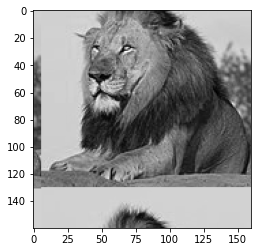

In [ ]:
translate_lion = translate(lion, 50,50) #Translate the lion
print("Translated")
plt.imshow(translate_lion,cmap="gray")


Rotated


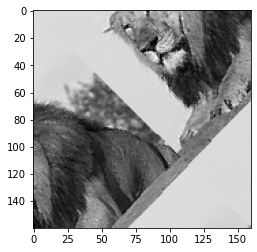

In [ ]:
rotate_lion = rotate(lion, 90) #rotated lion
print("Rotated")
plt.imshow(rotate_lion,cmap="gray")

Skewed


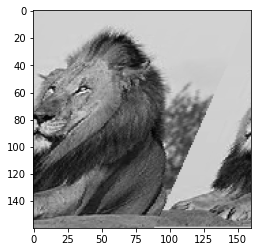

In [ ]:
skew_lion = skew(lion, 1)
print("Skewed")
plt.imshow(skew_lion,cmap="gray")

Flipped


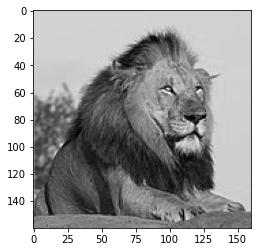

In [ ]:
flip_lion = flip_horizontal(lion) #flipped liion
print("Flipped")
plt.imshow(flip_lion,cmap="gray")

Gauss Noise


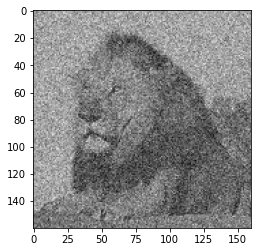

In [ ]:
gaussian_lion = gauss_noise(lion,50)
print("Gauss Noise")
plt.imshow(gaussian_lion,cmap="gray")

<h3 align="center"> Problem 2 </h3>
Take the sklearn digits dataset, make an 80-20 train-test split, then apply 
each of your transformations to the entire training set. You must decide good 
values of each of the parameters to use---justify each choice.
This should give you a larger (augmented) training set with roughly 8,600 
training points. Fit a random forest to the augmented training set and to the 
original training set and return the results of each on the test set. 

In [33]:
def image_augment(X,Y,parameters):
    """ transform the images using the functions above. 
    Parameters:
        X (N,d1,d2): array containing N images of dimension d1 x d2
        Y (N,): Labels/values for each image
        parameters: List of parameter values [A,B,theta,A,sigma2]
    Returns:
        augmented_X (6N,d1,d2): original and transformed data in one array 
        augmented_Y (6N): corresponding labels/values
    """
    #have to pass one at  a time
    augmented_X = []
    augmented_Y = []
    for image in X:
        translated = translate(image, parameters[0], parameters[1])
        rotated = rotate(image, parameters[2])
        skewed = skew(image, parameters[3])
        flipped = flip_horizontal(image)
        gaussed = gauss_noise(image, parameters[4])
        
        augmented_X.append(image) #append all the augmented stuff
        augmented_X.append(translated)
        augmented_X.append(rotated)
        augmented_X.append(skewed)
        augmented_X.append(flipped)
        augmented_X.append(gaussed)
        
    for label in Y:
        for j in range(6):
            augmented_Y.append(label) #add the labels

    return np.array(augmented_X), np.array(augmented_Y) #return the augmented arrays
    
        

In [40]:
from sklearn.datasets import load_digits
digits = load_digits()
y = 0

x_train1,x_test1,y_train1,y_test1 = train_test_split(digits['images'],digits.target,test_size=0.2)
rfc1 = RandomForestClassifier()
rfc1.fit(x_train1.reshape((len(x_train1),64)),y_train1)
rfc1_predicted= rfc1.predict(x_test1.reshape((len(x_test1),64)))


augX, augY = image_augment(digits['images'], digits.target, [0.1,0.1,-.01,0.1,.5]) #[8,8,1,10,1] [3,3,0,5,1]

x_train2,x_test2,y_train2,y_test2 = train_test_split(augX,augY,test_size=0.2)

reshaped = x_train2.reshape((len(x_train2),64))

#Second Random forest
rfc = RandomForestClassifier()
rfc.fit(reshaped, y_train2)
rfc_predicted = rfc.predict(x_test2.reshape((len(x_test2), 64)))

#print(classification_report(y_test2, rfc_predicted))
print("Not augmented: " + str(rfc1.score(x_test1.reshape((len(x_test1),64)), y_test1)), "Augmented: " + str(rfc.score(x_test2.reshape((len(x_test2),64)), y_test2)))

Not augmented: 0.9805555555555555 Augmented: 0.9819193324061196


<h2 align="center">Audio Augmentation</h2>

<h3 align="center"> Problem 3 </h3>
The file music.npy contains the audio time series data from 10 second clips of 150 different songs, with style.npy describing the associated style of ballroom dance. The styles included are Chacha, Foxtrot, Jive, Samba, Rumba, and Waltz. Use train_test_split
from sklearn.model_selection with test_size=.5 to create train and test sets. Create two training sets by augmenting this original training set. Each new augmented
training set will include the original data and the augmented data. For the first, add ambient
noise from the file restaurant-ambience.wav. For the second, use time_stretch.

In [ ]:
musicnpy =np.load('gdrive/My Drive/acme_data/music.npy')
stylenpy = np.load('gdrive/My Drive/acme_data/styles.npy')


#!unzip -uq "gdrive/My Drive/acme_data/music.zip" -d "gdrive/My Drive/acme_data/"



restaurant, sample_rate = librosa.load('gdrive/My Drive/acme_data/restaurant-ambience.wav', sr = 22050)

restaurant_sample = []
for i in range(150):
  rand = np.random.randint(1,3000000) #Find random number so the samples aren't all the same
  restaurant_sample.append(restaurant[rand: rand + 110250])

new_train = musicnpy + restaurant_sample
new_train_with_noise = np.concatenate((musicnpy, new_train)) #With the added noise

#Now use time stretch
new_train = []
for i in range(150):
  new_train.append(librosa.effects.time_stretch(musicnpy[i], .9))

new_train_with_time_stretch = np.concatenate((musicnpy, np.array(new_train).T[:110250].T), axis = 0)



<h3 align="center"> Problem 4</h3>

Do the following steps 5 times:

• Use the original data set and the augmented data sets to fit three RandomForestClassifiers,
one only on the original data, one on the original data and the data with ambient noise
added, and one on the original data and the time stretched data.

• Score each classifier.

Print the mean score for each of the classifiers and print the standard deviation for the scores.


In [ ]:
x_train_orig,x_test_orig,y_train_orig,y_test_orig = train_test_split(musicnpy,stylenpy,test_size=0.5) #original testing set
x_train_noise,x_test_noise,y_train_noise,y_test_noise = train_test_split(new_train_with_noise,np.concatenate((stylenpy,stylenpy)),test_size=0.5) #restaurant testing set
x_train_time,x_test_time,y_train_time,y_test_time = train_test_split(new_train_with_time_stretch,np.concatenate((stylenpy,stylenpy)),test_size=0.5) #restaurant testing set

orig = [] #Initialize arrays
amb = []
time = []
for i in range(5):
  rfc1 = RandomForestClassifier() #First random forest
  rfc1.fit(x_train_orig,y_train_orig)
  rfc_origpredicted = rfc1.predict(x_test_orig)

  #Ambience
  rfc2 = RandomForestClassifier()
  rfc2.fit(x_train_noise,y_train_noise)
  rfc_amb_predicted = rfc2.predict(x_test_orig)

  #Time Stretch
  rfc3 = RandomForestClassifier()
  rfc3.fit(x_train_time,y_train_time)
  rfc_amb_predicted = rfc2.predict(x_test_time)


  orig.append(rfc1.score(x_test_orig, y_test_orig))
  amb.append(rfc2.score(x_test_noise, y_test_noise))
  time.append(rfc3.score(x_test_time, y_test_time))

orig = np.array(orig) #set as numpy arrays
amb = np.array(amb)
time = np.array(time)



print('\t\t Mean \t STD')
print('Original','\t',np.round(orig.mean(), 3),'\t',np.round(orig.std(),3))
print('Ambient Noise','\t',np.round(amb.mean(),3),'\t',np.round(amb.std(),3))
print('Time Stretch:','\t',np.round(time.mean(),3),'\t', np.round(time.std(),3))

		 Mean 	 STD
Original 	 0.221 	 0.025
Ambient Noise 	 0.637 	 0.016
Time Stretch: 	 0.253 	 0.022


<h2 align="center">SMOTE</h2>

<h3 align="center"> Problem 5 </h3>

Write a function that uses the synthetic minority oversampling technique to augment an imbalanced data set.
Your function should have the following characteristics:

Accept $X$, a matrix of minority class samples
       $N$, the number of samples to generate per original point
       $k$, the number of nearest neighbors.

For each original point in the sample, pick one of the $k$ nearest neighbors at random and generate a new point that lies between the two original values. 

Return an array containing the synthetic samples.


In [28]:
def smote(X,N,k):
    """ Generate synthetic points using the SMOTE method. Hint! Use KDTree :)
    Parameters:
        X (n,m): minority class samples
        N (int): number of samples to generate from each point
        k (int): number of nearest neighbors
    Returns:
        synthetic ndarray(N*n,m): synthetic minority class samples
    """
    tree = KDTree(X)
              
    dist, ind = tree.query(X[:], k=k+1)  #k + 1 because we ignore itself
    ind = ind.T[1:].T
    
    indices = [] #The indices of the nearest neighbor
    for i in ind:
      r = random.randint(0, 1)
      indices.append(i[r])

    list_ = []
    for i in range(len(indices)):
        list_2 = [] #subset
        for j in range(len(X[i])): #X is a matrix so we need the second length
            list_2.append(random.uniform(X[i][j], X[indices[i]][j]))
        list_.append(list_2)
    return np.array(list_)

<h3 align="center"> Problem 6 </h3>

The dataset found in creditcard.npy contains information about credit card purchases made over a two day period. 
Of the approximately 285,000 observations, 492 are fraudulent purchases. 
The last column indicates if the purchase was valid (0) or fraudulent (1). 

Do the following steps 10 times:

• Create a training and test set from the data using train_test_split from sklearn.
model_selection with test_size=.7.

• Use smote with N = 500 and k = 2 to augment the training set.

• Create two Gaussian Naïve Bayes classifiers (from sklearn.naive_bayes.GaussianNB),
one which wil be trained on only the original data and the other on the SMOTE augmented
data and the original data.

• Fit each classifier and find the recall and accuracy of each model.

Print the mean recall and mean accuracy of each model and and describe the findings.

In [30]:
cc = np.load('creditcard.npy')
cc_no_target = cc.T[0:-1].T
target = cc.T[-1]
x_train,x_test,y_train,y_test = train_test_split(cc_no_target,target,test_size=0.7) #original testing set

new_array = smote(x_train, 500, 2) #get synthetic minority from smote


print('Original','\t',np.round(mean_orig_recall,5),'\t', np.round(mean_orig_score,5))
print('SMOTE', '\t\t', np.round(mean_smote_recall,5), '\t', np.round(mean_smote_score,5))

NameError: name 'mean_orig_recall' is not defined